# Immothep
### *Thomas & Orkaëlle*

La société Immothep est une agence immobilière spécialisée dans le vente de biens de particuliers.

Possédant déjà un site internet, elle souhaite pouvoir intégrer à celui-ci, un module d'estimation. Elle possède les ressources nécessaires pour réaliser le code dit "front", ainsi que les ressources graphiques.

Elle ne possède cependant pas les compétences nécessaires pour la réalisation de l'API qui va permettre d'exposer ce nouveau service.

La société nous sollicite donc pour réaliser la partie API en utilisant les données Open Data des Demandes de Valeurs Foncières (DVF) sur l'année 2019.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import immothep_OH as oh

In [4]:
oh.check_folder()
oh.ensure_data_loaded()

Datas already douwnloaded.


In [21]:
import pandas as pd

In [17]:
raw_df = pd.read_csv('./DATAS/RAW/valeursfoncieres-2019.txt', sep = '|')

&lt;matplotlib.axes._subplots.AxesSubplot at 0x2174155d130&gt;

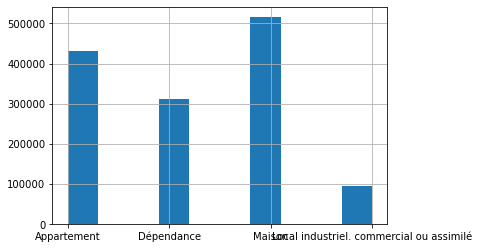

In [18]:
raw_df['Type local'].hist()

&lt;matplotlib.axes._subplots.AxesSubplot at 0x2162975e7f0&gt;

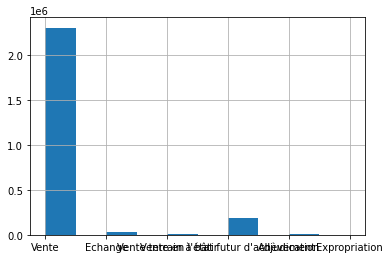

In [8]:
raw_df['Nature mutation'].hist()

In [19]:
df = raw_df[['Nature mutation','Valeur fonciere','Code postal','Code departement','Type local','Surface reelle bati','Nombre pieces principales','Surface terrain']]

In [20]:
df = df.loc[(df['Nature mutation'] == 'Vente') & ((df['Type local'] == 'Maison') | (df['Type local'] == 'Appartement'))]

&lt;matplotlib.axes._subplots.AxesSubplot at 0x21629832e20&gt;

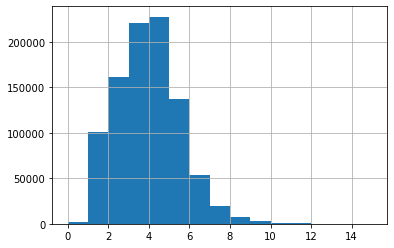

In [86]:
df['Nombre pieces principales'].hist(bins=15,range=(0,15))

&lt;matplotlib.axes._subplots.AxesSubplot at 0x21655d62f70&gt;

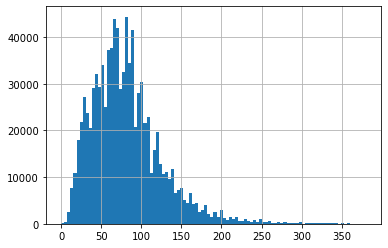

In [88]:
df['Surface reelle bati'].hist(bins=100, range=(0,380))